In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
import sys
import os
sys.path.append('/Users/vs/Dropbox/Python')
from IPython.display import Image
import sympy
from scipy import integrate
### From Gaia documentation to do command line requests to Gaia DR1 archive
import httplib
import urllib
import time
## for irsa dust maps
import astropy.coordinates as coord
from astroquery.irsa_dust import IrsaDust
### for emcee fitting
import emcee
import corner
from matplotlib.ticker import MaxNLocator


sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette(sns.husl_palette(10, l=.4))
colors = sns.color_palette()


# Fitting the RR Lyrae PL relation using a sample of RRL with fully sampled Spitzer light curves and TGAS parallaxes

In [48]:
path = os.chdir('/Users/vs/Dropbox/Python/gaia_sprints/')

merged_df = pd.read_csv('rr_calibrators.csv', header=0, sep=',')

# Getting a distance from a parallax



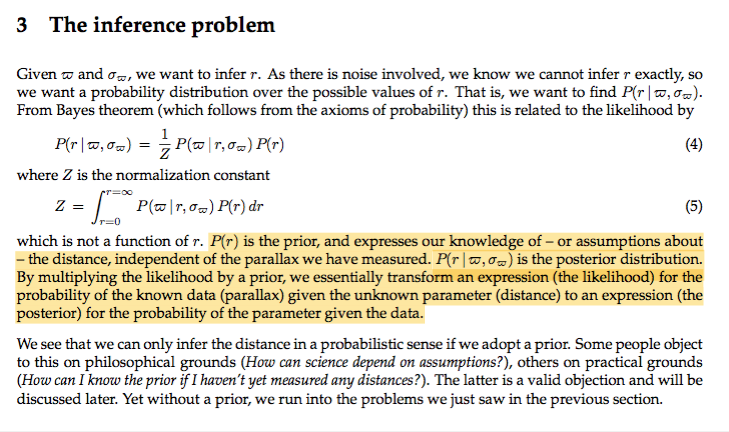

In [49]:
Image('parallax_distance.png')

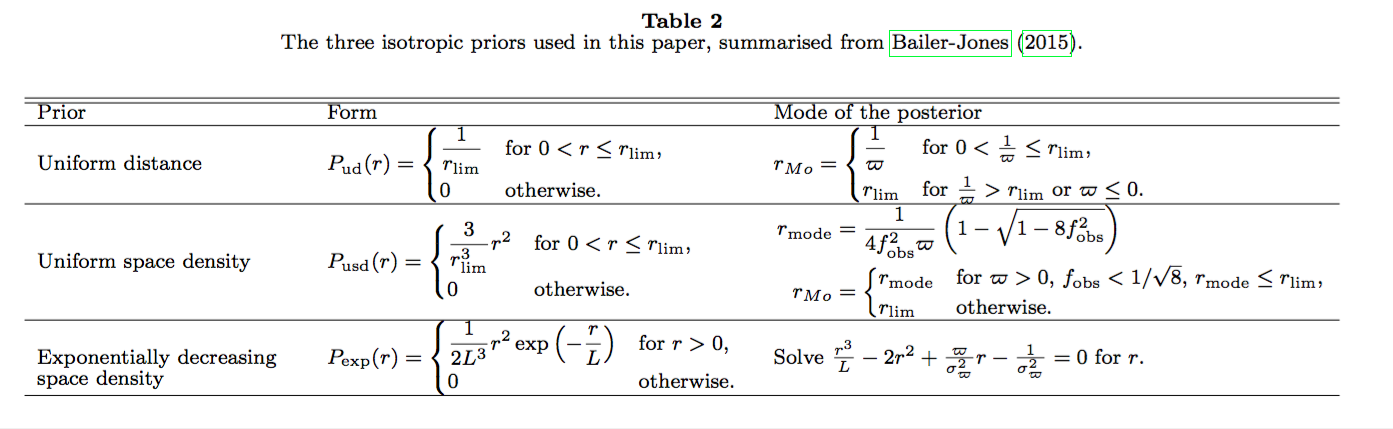

In [50]:
Image('priors.png')

Going to assume the *uniform space density* prior

Also set up:

$$M_\lambda = a_\lambda \log P + b_\lambda Z + c_\lambda$$

$$ M_\lambda = m_\lambda - \mu_{0} - A_\lambda$$

$$ \mu_0 = 5 \log r - 5$$

$$\theta = [ \left\{ r \right\}_{N}, \left\{ Z_{0} \right\}_{N}, \left\{ m_{0} \right\}_{N}, \left\{ A_{0} \right\}_{N}, a, b, c, S, \Delta ]$$

Where $\left\{ r \right\}_{N} \left\{ Z_{0} \right\}_{N}, \left\{ m_{0} \right\}_{N}, \left\{ A_{0} \right\}_{N}$ are the true distance, metallicity, apparent magnitude and extinction of each star -> $4N$ parameters, but will marginalise (integrate) over these.

$a, b, c$, are the PL fitting parameters -> $3$ params

$S$ is a scaling value to scale the uncertainties on the metallicities, such that $\sigma_{Z, true}^2  = (\sigma_{Z}^2 + S^2)$ -> 1 parameter -- Fix to 1 to start with

$\Delta$ is the intrinsic dispersion of the PL relation - assuming a uniform distribution **not a gaussian distribution** -> 1 parameter

** Total 4N + 8 parameters ** in each fit

** Data has 5N parameters to work with** (log P, mag, Z, $\sigma_{mag}$, $\sigma_{Z}$ per star)

## Likelihood, priors, and posterior for distance, magnitude and PL relation:

### Likelihoods:

Parallax $\varpi$, given true distance $r$ and measured uncertainty $\sigma_{\varpi}$:

$$ P(\varpi | r, \sigma_{\varpi}) = \frac{1}{\sqrt{2\pi}\sigma_\varpi}\exp{\left[-\frac{1}{2\sigma_{\varpi}^{2}}\left(\varpi - \frac{1}{r}\right)^2\right]} \text{ where } \sigma_{\varpi} \geq 0$$

Metallicity Z, given true metallicity Z$_{true}$ and uncertainty $\sigma_Z$ and scaling parameter S:

$$  P(Z~|~Z_{0}, \sigma_{Z}, S) =  \frac{1}{\sqrt{2\pi(\sigma_{Z}^2 + S^2)}} \exp{\left[-\frac{\left(Z - Z_{0}\right)^2}{2(\sigma_{Z}^2 + S^2)}\right]} $$

Extinction $A_{\lambda}$, given true extinction $A_{0}$ and uncertainty $\sigma_A = A_{\lambda}$

Note: The approximation that $\sigma_A = A_{\lambda}$ only holds in the Spitzer bands where $A$ is small and we're being conservative

$$  P(A_{\lambda}~|~A_{0}) = \frac{1}{\sqrt{2\pi}A_{\lambda}}\exp{\left[-\frac{\left(A_{\lambda} - A_{0} \right)^2}{2 A_{\lambda}^{2}}\right]} $$

Apparent magnitude $m_{\lambda}$, given true apparent magnitude $m_{0}$ and photometric uncertainty $\sigma_{m}$

$$ P(m_{\lambda}~|~m_{0}) = \frac{1} {\sqrt{2\pi}\sigma_{m}} \exp {\left[-\frac{\left(m_{\lambda} - m_{0} \right)^2}{2 \sigma_{m}^{2}}\right]} $$

PL relation, assuming we're sampling from a uniformly filled instability strip

$$ 
\begin{align}
P(M~|~\Delta, a, b, c, \log P, Z) & = \frac{1}{\Delta} && \text{where } \left| ~M - \left(a \log P + bZ + c\right)~\right| < \Delta \\
& = 0 && \text{otherwise}
\end{align}
$$

Apparent magnitude m, given the absolute magnitude, M, distance, r, and extinction $A_{0}$

$$ P(m_{0}~|~ M, r, A_{0}) = \delta \left[ m_{0} - \left(M + A_{0} - 5 + 5 \log r \right) \right] $$

### Priors:

### Uniform space density:

$$ 
\begin{align}
P_{usd}(r) = & ~\frac{3}{r^{3}_{lim}} r^{2} && \text{ for } 0 < r \leq r_{lim} \\
 = & ~0 && \text{ otherwise} \\
\end{align}
$$

where $r_{lim} = 20$ kpc for this test

I just made $r_{lim}$ arbitrarily large.


### metallicity:

Wide gaussian centered on mean metallicity of sample, $\sigma = 1$

$\mu_{ab} = -1.23$ dex

    
$$ P(Z) = \frac{1}{\sqrt{2\pi}} \exp \left[ -\frac{1}{2}\left(Z - \mu) \right)^2\right]$$

### extinction:

Wide gaussian centered on mean extinction of sample, $\sigma = \mu$

$\mu_{ab} = 0.1325$ mag

    
$$ P(A_{\lambda}) = \frac{1}{\sqrt{2\pi}\mu} \exp \left[ -\frac{1}{2}\left( \frac{A_{\lambda} - \mu }{\mu}\right)^2\right]$$

### Posterior:

Want to find the parameters of the PL fit, $a, b, c, \sigma_{a}, \sigma_b, \sigma_c, \Delta$

As a byproduct, will find the absolute mags $\{M\}_N$, distances, $\{r\}_N$, true metallicities, apparent mags and extinctions, $\left\{ Z_{0} \right\}_{N}, \left\{ m_{0} \right\}_{N}, \left\{ A_{0} \right\}_{N}$, and the scaling factor $S$ for the metallicity uncertainties


Denote data by $\{Y\}_N$, referring to observed apparent mags, metallicities, extinctions, $\log P$:

$$P(\theta ~ |~ \{Y\}_N) = \frac {P(\varpi | r, \sigma_{\varpi}) P(Z~|~Z_{0}, \sigma_{Z}, S)  P(A~|~A_{0}) P(m~|~m_{0}) P(M~|~\Delta, a, b, c, \log P, Z) P(m~|~ M, r, A_{0}) P_{usd}(r)P(Z_0)P(A_0)}
{\int \int \int \int \int P(\varpi | r, \sigma_{\varpi}) P(Z~|~Z_{0}, \sigma_{Z}, S)  P(A~|~A_{0}) P(m~|~m_{0}) P(M~|~\Delta, a, b, c, \log P, Z) P(m~|~ M, r, A_{0})P_{usd}(r)P(Z_0)P(A_0) dr dA_{0} dm_{0} dM dZ_0}$$ 

Advice from Adrian, Brani was that we don't need to solve for the denominator each time as that's just a scaling factor. Only need to find the numerator of the posterior, so the posterior immediately simplifies to:

$$P(\theta ~ |~ \{Y\}_N) = P(\varpi | r, \sigma_{\varpi}) P(Z~|~Z_{0}, \sigma_{Z}, S)  P(A~|~A_{0}) P(m~|~m_{0}) P(M~|~\Delta, a, b, c, \log P, Z) P(m~|~ M, r, A_{0}) P_{usd}(r)P(Z_0)P(A_0) $$


### Data:

x = $\log$ P

y = magnitude

z = Z

A = extinction

varpi = parallax




dy = magnitude error

dz = metallicity error

dp = parallax error

### Parameters

theta[0] = array of r's

theta[1] = array of true metallicities

theta[2] = array of true apparent magnitudes

theta[3] = array of true extinctions

theta[4] = a

theta[5] = b

theta[6] = c

theta[7] = S

theta[8] = $\Delta$

### Split these into two arrays - theta_data and theta_params

theta_data[0] = r array

theta_data[1] = true metallcity array

theta_data[2] = apparent mag array

theta_data[3] = extinction array


theta_params[0] = a

theta_params[1] = b

theta_params[2] = c

theta_params[3] = S

theta_params[4] = $\Delta$

In [51]:
def ln_uniform_dist_prior(theta_data):
    r_lim = 20e3
    r = theta_data[0]
    if (np.any(r) < 0 or np.any(r) >= r_lim):
        return -np.inf
    else:
        lnprior = np.sum(np.log(3.*r**2)/(r_lim**3))
        return lnprior

In [52]:
def ln_distance_likelihood(theta_data, varpi, dp):
    r = theta_data[0]
    like = 1./(sqrt(2.*np.pi*(dp**2)))*np.exp(- ((varpi - 1./r)**2)/(2*(dp**2)))
    ln_like = np.sum(np.log(like))
    return (ln_like)


In [53]:
def ln_metallicity_likelihood(theta_data, theta_params, z, dz):
    S = theta_params[3]
    z_model = theta_data[1]
    like = 1./(np.sqrt(2.*np.pi*(dz**2 + S**2))) *np.exp(-(z - z_model)**2/(2*(dz**2 + S**2)))
    ln_like = np.sum(np.log(like))
    return (ln_like)

In [54]:
def ln_metal_prior(theta_data):
    z_model = theta_data[1]
    z_mean = -1.23
    prior = 1./(np.sqrt(2.*np.pi)) * np.exp(-((z_model - z_mean)**2) /2 )
    ln_prior = np.sum(np.log(prior))
    return (ln_prior)

In [55]:
def ln_extinction_likelihood(theta_data, A):
    a_model = theta_data[3]
    like = 1./(np.sqrt(2.*np.pi*A**2)) *np.exp(-(A - a_model)**2/(2*(A**2)))
    ln_like = np.sum(np.log(like))
    return(ln_like)

In [56]:
def ln_extinction_prior(theta_data):
    a_mean = 0.1325
    a_model = theta_data[3]
    prior = 1./(np.sqrt(2.*np.pi)) * np.exp(-0.5((a_model - a_mean)/a_mean)**2 )
    ln_prior = np.sum(np.log(prior))
    return(ln_prior)

In [57]:
def ln_apmag_likelihood(theta_data, y, dy):
    m_model = theta_data[2]
    like = 1./sqrt(2.*np.pi*(dy**2))*np.exp(-((y - m_model)**2)/(2*(dy**2)))
    ln_like = np.sum(np.log(like))
    return (ln_like)

    

In [58]:
def ln_abs_likelihood(theta_params, theta_data, y, A):
    a = theta_params[0]
    b = theta_params[1]
    c = theta_params[2]
    abs_mag = ap_abs(theta_data, y, A)
    like = sympy.DiracDelta(y, abs_mag)
    ln_like = np.sum(np.log(like))
    return ln_like

In [59]:
def ap_abs(theta_data, y, A):
    r = theta_data[0]
    abs_mag = y - A + 5 - np.log10(r)
    return(abs_mag)

In [60]:
def ln_uniform_pl_likelihood(theta_params, theta_data, x, y, z, A):
    a = theta_params[0]
    b = theta_params[1]
    c = theta_params[2]
    model = a*x + b*z + c
    Delta = theta_params[4]
    abs_mag = ap_abs(theta_data, y, A)
    deviation = abs_mag - model
    like = []
    for count in np.arange(len(theta_data[0])):
        if np.abs(deviation[count]) < Delta:
            np.append(like, 1./Delta)
        else:
            np.append(like, -np.inf)
    ln_like = np.sum(np.log(like))
    return(ln_like)

In [63]:
def log_posterior(theta_data, theta_params, x, y, z, A, varpi, dy, dz, dp):
    
    ln_post = ln_uniform_dist_prior(theta_data) + ln_distance_likelihood(theta_data, varpi, dp) + ln_metallicity_likelihood(theta_data, theta_params, z, dz) + ln_metal_prior(theta_data) + ln_extinction_likelihood(theta_data, A) + ln_extinction_prior(theta_data) + ln_apmag_likelihood(theta_data, y, dy) + ln_abs_likelihood(theta_params, theta_data, y, A) + ln_uniform_pl_likelihood(theta_params, theta_data, x, y, z, A)  
    
    return ln_post

In [64]:
ab_df = merged_df.where(merged_df.Type=='ab').dropna(axis=0, how='all')
ab_df = ab_df.reset_index(drop=True)

In [65]:
x = ab_df.log_P
y = ab_df.mag_3p6
dy = ab_df.err_3p6
z = ab_df.Z
dz = np.ones(len(x))*0.15
varpi = ab_df.Plx
dp = ab_df.e_Plx
A = ab_df.A_3p6


In [66]:
ndim_theta = 4  # number of parameters in the model
ndim_alpha = 5
nwalkers = 500  # number of MCMC walkers

# initialize walkers
#starting_guesses = np.random.randn(nwalkers, ndim)

starting_theta = np.random.randn(ndim_theta, nwalkers, len(ab_df))
starting_alpha = np.random.randn(ndim_alpha, nwalkers)


starting_theta[0] = np.random.randn(nwalkers, len(ab_df)) ## r
starting_theta[1] = np.random.randn(nwalkers, len(ab_df)) ## Z
starting_theta[2] = np.random.randn(nwalkers, len(ab_df)) ## m
starting_theta[3] = np.random.randn(nwalkers, len(ab_df)) ## A

starting_alpha[0] = np.random.randn(nwalkers) ## a
starting_alpha[1] = np.random.randn(nwalkers) ## b
starting_alpha[2] = np.random.randn(nwalkers) ## c
starting_alpha[3] = np.ones(nwalkers)*0.1 ## S
starting_alpha[4] = np.random.randn(nwalkers) ## Delta

In [67]:
starting_guesses = (starting_theta, starting_alpha)

sampler = emcee.EnsembleSampler(nwalkers, 9, log_posterior,
                                args=[x, y, z, dy, dz, varpi, dp, A])
pos, prob, state = sampler.run_mcmc(starting_guesses, 300)



TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [31]:
fig, ax = mp.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
  

Index([u'Name', u'Period', u'Type', u'id_compare', u'mag_3p6', u'err_3p6',
       u'amp_3p6', u'mag_4p5', u'err_4p5', u'amp_4p5', u'rad', u'HIP', u'TYC2',
       u'SolID', u'Source', u'RandomI', u'Epoch', u'RA_ICRS', u'e_RA_ICRS',
       u'DE_ICRS', u'e_DE_ICRS', u'Plx', u'e_Plx', u'pmRA', u'e_pmRA', u'pmDE',
       u'e_pmDE', u'RADEcor', u'RAPlxcor', u'RApmRAcor', u'RApmDEcor',
       u'DEPlxcor', u'DEpmRAcor', u'DEpmDEcor', u'PlxpmRAcor', u'PlxpmDEcor',
       u'pmRApmDEcor', u'NAL', u'NAC', u'NgAL', u'NgAC', u'NbAL', u'NbAC',
       u'DQ', u'epsi', u'sepsi', u'APF', u'ARF', u'WAL', u'WAC', u'Apr',
       u'MatchObs', u'Dup', u'sK1', u'sK2', u'sK3', u'sK4', u'mK1', u'mK2',
       u'mK3', u'mK4', u'o_<Gmag>', u'<FG>', u'e_<FG>', u'<Gmag>', u'Var',
       u'GLON', u'GLAT', u'ELON', u'ELAT', u'A_3p6', u'A_4p5', u'[Fe/H]',
       u'log_P', u'log_P_f'],
      dtype='object')

In [72]:
starting_guesses = np.concatenate(starting_theta, starting_alpha)


TypeError: only length-1 arrays can be converted to Python scalars

In [71]:
starting_guesses.

AttributeError: 'tuple' object has no attribute 'type'

In [68]:
starting_theta.shape, starting_alpha.shape

((4, 500, 28), (5, 500))

In [100]:
test = np.row_stack((starting_theta, starting_alpha[:,:, np.newaxis]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [94]:
## Bad fit:

def free_fit(logp, slope, zp):
    av_p = np.mean(logp)
    return slope*(logp - av_p) + zp


popt, pcov = curve_fit(free_fit, ab_df['log_P'],ab_df['M_3p6'])

fit_df_final = fit_df_final.append({'slope': popt[0], 'e_slope': pcov[0][0], 'zeropoint': popt[1], 'e_zeropoint': pcov[1][1], 'mean_logp' : np.mean(ab_df['log_P']), 'source': 'FreeFit', 'type': 'ab', 'band': '3p6', 'sample' : 'complete', 'n_stars': len(ab_df['M_3p6']!=np.nan)}, ignore_index=True)

slope = popt[0]
e_slope = pcov[0][0]
zp = popt[1]
e_zp = pcov[1][1]
mean = np.mean(ab_df['log_P'])

axp2.fill_between(p1, ((slope+(2*e_slope))*(p1-mean) + zp - 2*e_zp), ((slope-(2*e_slope))*(p1-mean) + zp + 2*e_zp), alpha = 0.3, color=col)

axp2.plot(p1, slope*(p1-mean)+ zp, ls='--', label="[3.6]", color=col)
axp2.errorbar(ab_df['log_P'], ab_df['M_3p6'], yerr = ab_df.e_M_3p6_tgas, ls='None',zorder=4, color='Grey', label='_nolegend_')
axp2.errorbar(ab_df.log_P, ab_df.M_3p6, yerr = ab_df.e_M_3p6_gks, ls='None',zorder=4, color=col, label='_nolegend_')
axp2.plot(ab_df.log_P, ab_df.M_3p6, 'o', color=col, ls='None', zorder=4, markeredgecolor='Grey', markeredgewidth=1, label='_nolegend_')
mp.ylabel('Absolute Magnitude 3.6 $\mu$m')

xticklabels = axp2.get_xticklabels()
mp.setp(xticklabels, visible=False)
axp2.set_yticks([0, -2, -4, -6])


ValueError: total size of new array must be unchanged

# cells for reading in data from scratch --- run below:

In [2]:
### only run if starting from scratch

crrp_stars = pd.read_csv('vizer_crossmatch.tsv', skiprows=166, skipinitialspace=True, names=('input', 'rad', 'HIP', 'TYC2', 'SolID', 'Source', 'RandomI', 'Epoch', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor', 'RApmRAcor', 'RApmDEcor', 'DEPlxcor', 'DEpmRAcor', 'DEpmDEcor', 'PlxpmRAcor', 'PlxpmDEcor', 'pmRApmDEcor', 'NAL', 'NAC', 'NgAL', 'NgAC', 'NbAL', 'NbAC', 'DQ', 'epsi', 'sepsi', 'APF', 'ARF', 'WAL', 'WAC', 'Apr', 'MatchObs', 'Dup', 'sK1', 'sK2', 'sK3', 'sK4', 'mK1', 'mK2', 'mK3', 'mK4', 'o_<Gmag>', '<FG>', 'e_<FG>', '<Gmag>', 'Var', 'GLON', 'GLAT', 'ELON', 'ELAT'), na_values='NOT_AVAILABLE', sep=';', comment='#')
crrp_stars['ID'] = crrp_stars.input.str.split('\t',0).str.get(0)

crrp_stars = crrp_stars.drop('input', 1)
#crrp_stars = crrp_stars.drop('rad', 1)
crrp_stars = crrp_stars.replace('', np.nan)
crrp_stars['ID'] = crrp_stars['ID'].replace(regex=True, to_replace=r' ',value='_')
crrp_stars['id_compare'] = map(str.lower, crrp_stars.ID)
crrp_stars['id_compare'] = crrp_stars['id_compare'].replace(regex=True, to_replace=r'_',value='')
crrp_stars = crrp_stars.groupby(['ID']).min()


In [3]:
crrp_stars.head()

,rad,HIP,TYC2,SolID,Source,RandomI,Epoch,RA_ICRS,e_RA_ICRS,DE_ICRS,...,o_<Gmag>,<FG>,e_<FG>,<Gmag>,Var,GLON,GLAT,ELON,ELAT,id_compare
ID,,,,,,,,,,,,,,,,,,,,,
AB_Uma,0.0058,59411.0,NaN,1635378410781933568,1546016668386865792,1004237,2015.0,182.810685,0.149,47.828763,...,105,8.257196e+05,7685.37020,10.733,NaN,141.042099,67.861413,158.465090,43.874357,abuma
AM_Tuc,0.0095,6115.0,NaN,1635378410781933568,4692528057537147136,1393825,2015.0,19.627973,0.265,-67.918161,...,124,3.928950e+05,4741.63750,11.539,NaN,299.059083,-49.006000,324.481499,-64.212527,amtuc
AN_Ser,0.0026,77830.0,NaN,1635378410781933568,1191509999055192960,619871,2015.0,238.379390,0.194,12.961105,...,212,6.546377e+05,10730.71765,10.985,NaN,23.802692,45.232103,232.759715,32.403224,anser
AV_Peg,0.0042,107935.0,NaN,1635378410781933568,1793460110951463424,1471347,2015.0,328.011708,0.199,22.574791,...,85,1.103026e+06,29572.87476,10.418,NaN,77.443012,-24.053691,339.290110,33.146829,avpeg
BH_Peg,0.0169,112994.0,NaN,1635378410781933568,2828497064068310784,1634489,2015.0,343.254215,0.198,15.787682,...,104,1.159717e+06,14555.13569,10.364,NaN,85.614589,-38.356182,350.987445,21.094589,bhpeg


In [4]:
info_df = pd.read_csv('rrl_average_mags', delim_whitespace=True)
info_df.head()

,Name,Period,Type,id_compare,mag_3p6,err_3p6,amp_3p6,mag_4p5,err_4p5,amp_4p5
0,ABUma,0.600,ab,abuma,9.598,0.003,0.171,9.587,0.003,0.177
1,AMTuc,0.406,c,amtuc,10.602,0.002,0.127,10.565,0.002,0.142
2,ANSer,0.522,ab,anser,9.801,0.004,0.289,9.795,0.004,0.299
3,APSer,0.341,c,apser,10.213,0.002,0.111,10.202,0.002,0.122
4,AVPeg,0.390,ab,avpeg,9.332,0.004,0.281,9.329,0.004,0.281


In [5]:
merged_df = info_df.merge(crrp_stars, on='id_compare')
merged_df

,Name,Period,Type,id_compare,mag_3p6,err_3p6,amp_3p6,mag_4p5,err_4p5,amp_4p5,...,mK4,o_<Gmag>,<FG>,e_<FG>,<Gmag>,Var,GLON,GLAT,ELON,ELAT
0,ABUma,0.600,ab,abuma,9.598,0.003,0.171,9.587,0.003,0.177,...,9.267754,105,8.257196e+05,7685.37020,10.733,NaN,141.042099,67.861413,158.465090,43.874357
1,AMTuc,0.406,c,amtuc,10.602,0.002,0.127,10.565,0.002,0.142,...,-17.344803,124,3.928950e+05,4741.63750,11.539,NaN,299.059083,-49.006000,324.481499,-64.212527
2,ANSer,0.522,ab,anser,9.801,0.004,0.289,9.795,0.004,0.299,...,-19.213884,212,6.546377e+05,10730.71765,10.985,NaN,23.802692,45.232103,232.759715,32.403224
3,AVPeg,0.390,ab,avpeg,9.332,0.004,0.281,9.329,0.004,0.281,...,30.296535,85,1.103026e+06,29572.87476,10.418,NaN,77.443012,-24.053691,339.290110,33.146829
4,BHPeg,0.641,ab,bhpeg,9.002,0.003,0.237,8.982,0.003,0.236,...,31.870094,104,1.159717e+06,14555.13569,10.364,NaN,85.614589,-38.356182,350.987445,21.094589
5,BXLeo,0.363,c,bxleo,10.678,0.002,0.107,10.670,0.002,0.122,...,-15.991236,70,4.162361e+05,5720.86812,11.476,NaN,241.078445,69.984066,168.310156,12.988380
6,CSEri,0.311,c,cseri,8.126,0.002,0.117,8.110,0.002,0.117,...,44.986927,193,4.172558e+06,47371.36513,8.974,NaN,256.317812,-63.387143,15.201311,-54.053147
7,DXDel,0.473,ab,dxdel,8.653,0.004,0.249,8.641,0.004,0.258,...,24.143590,78,1.771644e+06,13135.50447,9.904,NaN,58.469794,-18.844886,318.268456,29.160267
8,HKPup,0.734,ab,hkpup,9.884,0.004,0.252,9.854,0.004,0.257,...,-30.420750,111,5.056835e+05,6778.87633,11.265,NaN,230.724295,5.543249,121.137119,-33.749926
9,MTTel,0.317,c,mttel,8.078,0.002,0.126,8.064,0.002,0.111,...,35.748550,45,4.282056e+06,66644.82592,8.946,NaN,350.239779,-21.117388,281.605877,-23.839117


# Spitzer-TGAS sample

Spitzer-TGAS sample has 40 stars with fully sampled lightcurves and TGAS parallaxes

# Auxilliary data

Adding in some auxilliary data
* Extinction:
 - IRSA dust service provides both Schlegel, Finkbeiner & Davis (1998) and Schlafly & Finkbeiner (2011) results in the table. 

 - Adopting the S&F (2011) values here.

 - Systematic uncertainties in their work approx 0.02 mag. Statistical on the order of millimag. Need to read the paper in more detail.
 
* Metallicities:
 - Adopting values from Feast et al. (2008)
 - Uncertainties $\pm$ 0.15 dex per star.
 - Some have better uncertainties, will update these on a star by star basis.
 - Right now, assuming worst case scenario that all have uncertainty of 0.15 dex.

In [ ]:
def grab_extinction(row):
    star = row.Name
    ra = row.RA_ICRS
    dec = row.DE_ICRS
    coord_string = str(ra) + 'd ' +  str(dec) + 'd'
    C = coord.SkyCoord(coord_string, frame='fk5')
    table = IrsaDust.get_extinction_table(coordinate=C)
    irac_1_sandf = table[19][3]
    irac_2_sandf = table[20][3]
    merged_df.ix[merged_df.Name==star, 'A_3p6'] = irac_1_sandf
    merged_df.ix[merged_df.Name==star, 'A_4p5'] = irac_2_sandf
    print star, ' A_3p6: ', irac_1_sandf, ' A_4p5: ', irac_2_sandf
    return(0)

    

In [20]:
feast_df = pd.read_csv('Feast_2008.tsv', sep=';', skiprows=64, names=('HIP', 'Name', 'plx', 'e_plx', 'Vmag', 'Jmag', 'Hmag', 'Ksmag', 'Per', 'Z', 'E(B-V)', 'Type', 'Simbad', '_RA', '_DE'))

feast_df['id_compare'] = map(str.lower, feast_df.Name)
feast_df['id_compare'] = feast_df['id_compare'].replace(regex=True, to_replace=r' ',value='')
feast_metals = ['id_compare', 'Z']
feast_df.head()

merged_df.apply(lambda line: grab_extinction(line), axis=1)

merged_df = merged_df.merge(feast_df[feast_metals], on='id_compare')

,HIP,Name,plx,e_plx,Vmag,Jmag,Hmag,Ksmag,Per,Z,E(B-V),Type,Simbad,_RA,_DE,id_compare
0,226,RU Scl,0.99,1.96,10.22,9.474,9.294,9.229,0.493347,-1.27,0.018,,Simbad,0.70046,-24.94530,ruscl
1,320,UU Cet,1.59,5.73,12.08,11.137,10.863,10.837,0.606080,-1.28,0.021,,Simbad,1.02135,-16.99764,uucet
2,1878,SW And,-0.01,1.84,9.71,8.809,8.578,8.505,0.442262,-0.24,0.038,,Simbad,5.92954,29.40101,swand
3,2655,RX Cet,3.24,4.74,11.44,10.606,10.378,10.319,0.573685,-1.28,0.025,,Simbad,8.40952,-15.48745,rxcet
4,4541,W Tuc,5.37,2.41,11.41,10.594,10.373,10.344,0.642260,-1.57,0.021,,Simbad,14.54042,-63.39566,wtuc


## log P and fundamentailised period

* Adding an extra column for log(P)
* Adding another column for fundamentalised period
 - for RRab, log_P_f = log_P
 - for RRc, log_P_f = log_P + 0.127

In [10]:
merged_df['log_P'] = np.log10(merged_df['Period'])
merged_df['log_P_f'] = np.where(merged_df['Type']=='c', merged_df['log_P'] + 0.127, merged_df['log_P'])

merged_df = merged_df.rename(columns = {'[Fe/H]': 'Z'})


merged_df.to_csv('rr_calibrators.csv', header=True, index=False)

In [45]:
ndim_theta = 4  # number of parameters in the model
ndim_alpha = 5
nwalkers = 100  # number of MCMC walkers

starting_theta = np.random.randn(ndim_theta, nwalkers, len(ab_df))

starting_theta[0] = np.random.randn(100, len(ab_df)) ## r
starting_theta[1] = np.random.randn(100, len(ab_df)) ## Z
starting_theta[2] = np.random.randn(100, len(ab_df)) ## m
starting_theta[3] = np.random.randn(100, len(ab_df)) ## A


for count in np.arange(len(starting_theta[1])):
    print count

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [36]:
starting_theta.shape

(4, 100, 28)